In [1]:
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, RFECV, SelectFromModel
from sklearn.svm import SVR
from sklearn.cross_validation import KFold
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression, \
LogisticRegression, SGDRegressor, TheilSenRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from matplotlib import pyplot as plt
from pprint import pprint

In [2]:
data_1 = pd.read_csv("data/bioactivity-16_9-10-12.txt", sep="\t")
data_2 = pd.read_csv("data/malaria-osdd-16 9-10-05.txt", sep="\t")

In [3]:
# we want these columns from data_1: CANONICAL_SMILES, STANDARD_VALUE, STANDARD_UNITS
data_1 = data_1[["CMPD_CHEMBLID", "CANONICAL_SMILES", "STANDARD_VALUE", "STANDARD_UNITS"]]
# we want these columns from data_2: CANONICAL_SMILES, A1_STANDARD_VALUE, A1_STANDARD_UNITS
data_2 = data_2[["CHEMBLID", "CANONICAL_SMILES", "A1_STANDARD_VALUE", "A1_STANDARD_UNITS"]]

In [4]:
non_feature_colnames = ["chembl_id", "smiles", "activity_value", "activity_units"]
data_1.columns = data_2.columns = non_feature_colnames
# concat both tables
data = pd.concat([data_1, data_2])
len(data)

1101

In [5]:
# remove duplicated ligands by Chembl ID
data = data.drop_duplicates(subset="chembl_id")
len(data)

991

In [6]:
data.drop_duplicates(subset="activity_units")

,chembl_id,smiles,activity_value,activity_units
0,CHEMBL3219907,CCN1CCN(CC1)c2nc(Nc3ccc(Nc4ccnc5cc(Cl)ccc45)cc...,0.00211,ug.mL-1
9,CHEMBL2088548,C[C@@H]1CC[C@H]2[C@@H](C)[C@H](OC(=O)CCC(=O)NC...,0.30000,nM
127,CHEMBL3410086,CC(C)C[C@H](NC(=O)N1CCOCC1)c2occ(n2)C(=O)N[C@@...,NaN,NaN


In [7]:
# we want to drop rows with NaN activity value and convert ug.mL-1 activity units to nM
data = data[~np.isnan(data.activity_value)]

In [8]:
# add RDKit mol objects
data["rdmol"] = data.smiles.apply(AllChem.MolFromSmiles)
non_feature_colnames.append("rdmol")

In [9]:
def convert_units(row):
    if row["activity_units"] == "ug.mL-1":
        amount = row["activity_value"]
        # convert ug/ml to g/dm3
        # 1 ug = 10e-6 g, 1 ml = 10e-3
        # 10e-6/10e-3 = 10e-3
        amount = amount * 1e-3
        # now convert amount to nanomol/dm3 = nM
        row["activity_value"] = (amount/AllChem.CalcExactMolWt(row["rdmol"]))*1e9
        row["activity_units"] = "nM"
    return row
data = data.apply(convert_units, axis=1)

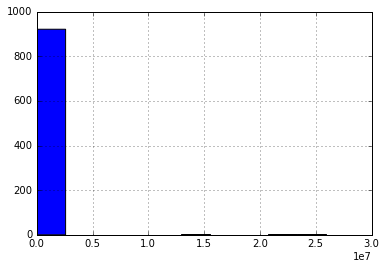

In [10]:
data.activity_value.hist()

In [11]:
for name, f in Descriptors.descList:
    data[name] = data.rdmol.apply(f)

In [12]:
features = np.asarray(data.drop(non_feature_colnames, axis=1))
activities = np.asarray(data.activity_value)

In [13]:
features.shape

(932, 196)

In [14]:
# remove descriptors with zero variance (= same values for all ligands)
features = VarianceThreshold(threshold=0.0).fit_transform(features)

In [15]:
features.shape

(932, 172)

In [16]:
#svr = SVR(kernel="poly")
#rfecv = RFECV(estimator=svr,
#              step=1,
#              cv=KFold(len(activities), n_folds=10, random_state=1),
#              scoring='accuracy')
#rfecv.fit(features, activities)

In [17]:
# feature selection with multiple Decision Trees
#clf = ExtraTreesRegressor(n_estimators=100).fit(features, activities)
clf = ExtraTreesRegressor(n_estimators=100, random_state=1).fit(features, activities)
model = SelectFromModel(clf, prefit=True)
features_fs = model.transform(features)
features_fs.shape

(932, 21)

In [18]:
# descriptors after feature selection
list(np.array(Descriptors.descList)[model.get_support(indices=True)][:, 0])

['MinAbsEStateIndex',
 'MolWt',
 'Chi4v',
 'PEOE_VSA1',
 'PEOE_VSA11',
 'PEOE_VSA4',
 'SMR_VSA5',
 'SMR_VSA7',
 'SlogP_VSA6',
 'EState_VSA1',
 'VSA_EState5',
 'VSA_EState6',
 'VSA_EState9',
 'NumAromaticHeterocycles',
 'fr_Ar_N',
 'fr_NH0',
 'fr_amide',
 'fr_diazo',
 'fr_dihydropyridine',
 'fr_epoxide',
 'fr_nitro_arom']

In [19]:
# standardize features
features = StandardScaler().fit_transform(features)
features_fs = StandardScaler().fit_transform(features_fs)

In [20]:
regressors = {"SVR": SVR(kernel="poly"),
              "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=100, n_jobs=-1),
              "RandomForestRegressor": RandomForestRegressor(n_estimators=100, n_jobs=-1),
              "ARDRegression": ARDRegression(),
              "BayesianRidge": BayesianRidge(),
              "LinearRegression": LinearRegression(n_jobs=-1),
              "SGDRegressor": SGDRegressor(),
              "TheilSenRegressor": TheilSenRegressor(n_jobs=-1)
             }

In [21]:
# 10-fold cross-validation
cv = KFold(len(activities), n_folds=10, random_state=1)

In [22]:
def train_test_score(regressor, features, activities, cv):
    scores = {
            "mean_absolute_error_list": [],
            "mean_squared_error_list": [],
            "r2_score_list": [],
            "explained_variance_score_list": []
        }
    
    for train_index, test_index in cv:
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = activities[train_index], activities[test_index]
        predicted = regressor.fit(X_train, y_train).predict(X_test)
        
        scores["mean_absolute_error_list"].append(mean_absolute_error(y_test, predicted))
        scores["mean_squared_error_list"].append(mean_squared_error(y_test, predicted))
        scores["r2_score_list"].append(r2_score(y_test, predicted))
        scores["explained_variance_score_list"].append(explained_variance_score(y_test, predicted))
        
    scores["mean_absolute_error_mean"] = np.mean(scores["mean_absolute_error_list"])
    scores["mean_squared_error_mean"] = np.mean(scores["mean_squared_error_list"])
    
    r2_scores = np.array(scores["r2_score_list"])
    scores["r2_score_mean"] = np.mean(r2_scores[(r2_scores >= -1.0) & (r2_scores <= 1.0)])
    
    evs_scores = np.array(scores["explained_variance_score_list"])
    scores["explained_variance_score_mean"] = np.mean(evs_scores[(evs_scores >= -1.0) & (evs_scores <= 1.0)])
    return scores

In [23]:
def format_float(f, acc=".2f"):
    return ("{:" + acc + "}").format(f)

In [24]:
def write_score(file, method_name=None, score=None, only_header=False):
    if only_header:
        with open(file, mode="w", encoding="utf-8") as f:
            f.write("{},{},{},{},{}\n".format("model",
                                           "mean_absolute_error",
                                           "mean_squared_error",
                                           "r2_score",
                                           "explained_variance_score"))
    else:
        with open(file, mode="a", encoding="utf-8") as f:
            f.write("{},{},{},{},{}\n".format(method_name,
                                           format_float(score["mean_absolute_error_mean"]),
                                           format_float(score["mean_squared_error_mean"]),
                                           format_float(score["r2_score_mean"]),
                                           format_float(score["explained_variance_score_mean"])
                                          ))

In [25]:
# train and test on not feature selected descriptors (172)
file = "output/scores.txt"
write_score(file, only_header=True)
for reg in regressors.keys():
    print("\nStarting model:", reg)
    score = train_test_score(regressors[reg], features, activities, cv)
    write_score(file,
                method_name=reg,
                score=score)
    print(reg, "done!")


Starting model: LinearRegression
LinearRegression done!

Starting model: RandomForestRegressor
RandomForestRegressor done!

Starting model: TheilSenRegressor
TheilSenRegressor done!

Starting model: ExtraTreesRegressor
ExtraTreesRegressor done!

Starting model: BayesianRidge
BayesianRidge done!

Starting model: SGDRegressor
SGDRegressor done!

Starting model: SVR
SVR done!

Starting model: ARDRegression
ARDRegression done!


In [26]:
# train and test on feature selected descriptors (21)
file = "output/scores_fs.txt"
write_score(file, only_header=True)
for reg in regressors.keys():
    print("\nStarting model:", reg)
    score = train_test_score(regressors[reg], features_fs, activities, cv)
    write_score(file,
                method_name=reg,
                score=score)
    print(reg, "done!")


Starting model: LinearRegression
LinearRegression done!

Starting model: RandomForestRegressor
RandomForestRegressor done!

Starting model: TheilSenRegressor
TheilSenRegressor done!

Starting model: ExtraTreesRegressor
ExtraTreesRegressor done!

Starting model: BayesianRidge
BayesianRidge done!

Starting model: SGDRegressor
SGDRegressor done!

Starting model: SVR
SVR done!

Starting model: ARDRegression
ARDRegression done!


In [27]:
# scores without feature selection
pd.read_csv("output/scores.txt", sep=",")

,model,mean_absolute_error,mean_squared_error,r2_score,explained_variance_score
0,LinearRegression,1.168151e+17,1669448277133099802631438716658253824.00,0.54,0.54
1,RandomForestRegressor,1.741619e+05,1453044499517.47,0.63,0.64
2,TheilSenRegressor,2.026827e+06,1268175652947446.50,0.22,0.23
3,ExtraTreesRegressor,1.558477e+05,1809196249295.19,0.48,0.49
4,BayesianRidge,5.031153e+05,5626110965428.02,-0.01,0.00
5,SGDRegressor,7.333099e+05,2077860248300.58,0.56,0.56
6,SVR,2.697400e+05,5685003036600.71,-0.03,0.00
7,ARDRegression,5.031153e+05,5626110965757.66,-0.01,0.00


In [28]:
# scores with feature selection
pd.read_csv("output/scores_fs.txt", sep=",")

,model,mean_absolute_error,mean_squared_error,r2_score,explained_variance_score
0,LinearRegression,601129.16,2.352466e+12,0.55,0.56
1,RandomForestRegressor,124293.73,9.713637e+11,0.72,0.74
2,TheilSenRegressor,275437.43,5.571079e+12,0.00,0.02
3,ExtraTreesRegressor,116647.37,9.605402e+11,0.73,0.74
4,BayesianRidge,503115.27,5.626111e+12,-0.01,0.00
5,SGDRegressor,612013.58,2.310379e+12,0.59,0.60
6,SVR,269667.73,5.682289e+12,-0.03,0.01
7,ARDRegression,503115.27,5.626111e+12,-0.01,0.00
